## Coastal Rainfall

In [2]:
import xarray as xr
from pyproj import Proj, transform
import geopandas as gpd
import numpy as np

data = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Rain\*.nc", parallel=True)

# Define the coordinate reference systems
wgs84 = Proj(init='epsg:4326')  # WGS84 coordinate system (latitude and longitude)
osgb36 = Proj(init='epsg:27700')  # OS National Grid coordinate system

# Load the shapefile with coastline coordinates
shapefile_path = r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\GBR_adm0.shp"
gdf_coastline = gpd.read_file(shapefile_path)

C:\Users\iarla\miniconda3\envs\jupyter-env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\iarla\miniconda3\envs\jupyter-env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [3]:
# Extract coordinates from the shapefile
lon_coastline = []
lat_coastline = []

# Iterate through each geometry in the GeoDataFrame
for geometry in gdf_coastline['geometry']:
    if geometry.geom_type == 'Polygon':
        # If it's a single Polygon, extract coordinates
        lon, lat = geometry.exterior.xy
        lon_coastline.extend(lon)
        lat_coastline.extend(lat)
    elif geometry.geom_type == 'MultiPolygon':
        # If it's a MultiPolygon, iterate through each Polygon
        for polygon in geometry.geoms:
            lon, lat = polygon.exterior.xy
            lon_coastline.extend(lon)
            lat_coastline.extend(lat)

In [4]:
# Convert shapefile coordinates to OS National Grid
easting_coastline, northing_coastline = transform(wgs84, osgb36, lon_coastline, lat_coastline)

# Round the coordinates to match the grid in the netcdf file
easting_coastline = np.round(easting_coastline, decimals=2)
northing_coastline = np.round(northing_coastline, decimals=2)

# Create a mask based on the coastline coordinates
coastline_mask = np.zeros_like(data['rainfall'].isel(time=0, drop=True), dtype=bool)
for easting, northing in zip(easting_coastline, northing_coastline):
    idx_x = np.abs(data['projection_x_coordinate'] - easting).argmin()
    idx_y = np.abs(data['projection_y_coordinate'] - northing).argmin()
    coastline_mask[idx_y, idx_x] = True

non_coastline_mask = ~coastline_mask
    
# Apply the mask to the climate data
coast = data['rainfall'].where(coastline_mask)
non_coast = np.array(data['rainfall'].where(non_coastline_mask))

coastal_data = np.array(coast)
non_coastal_data = np.array(non_coast)

C:\Users\iarla\AppData\Local\Temp\ipykernel_11208\3995120290.py:2: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  easting_coastline, northing_coastline = transform(wgs84, osgb36, lon_coastline, lat_coastline)


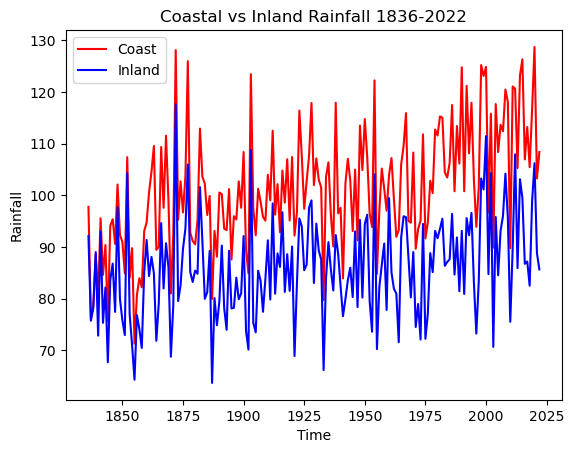

In [8]:
import matplotlib.pyplot as plt
from skimage.measure import block_reduce

tas_coast = block_reduce(coastal_data, block_size=(12, 1, 1), func=np.mean, cval=np.mean(coastal_data))
temp_coast = np.nanmean(tas_coast, axis=(1, 2))

tas_inland = block_reduce(non_coastal_data, block_size=(12, 1, 1), func=np.mean, cval=np.mean(non_coastal_data))
temp_inland = np.nanmean(tas_inland, axis=(1, 2))

time = np.arange(1836,2023)

plt.plot(time,temp_coast, 'r', label='Coast')
plt.plot(time, temp_inland, 'b', label='Inland')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.title('Coastal vs Inland Rainfall 1836-2022')
plt.legend()

The rate of change of the annual Coast temperature is 0.11631 ± 0.01325 mm
95% Confidence Interval for the slope: (0.09, 0.14)
T statistic Coast 8.777461439104751
P-value Coast 1.1102230246251565e-15
Z-score Coast 8.777461439104751
The rate of change of the annual temperature for inland of U.K. is 0.05471 ± 0.01265 mm
95% Confidence Interval for the slope: (0.03, 0.08)
T statistic Inland 4.326056026587283
P-value Inland 2.4800401420721485e-05
Z-score Inland 4.326056026587283


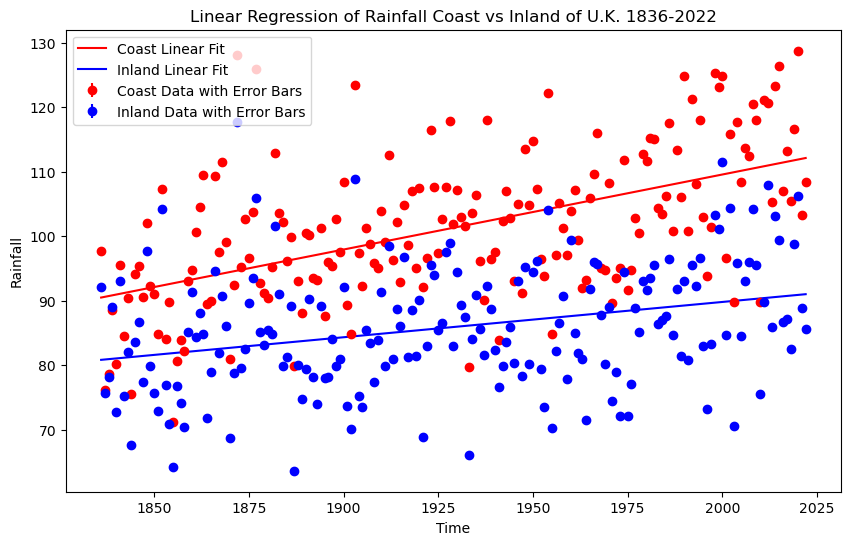

In [9]:
import statsmodels.api as sm
from scipy import stats

err = 0.001

X_with_constant_Coast = sm.add_constant(time)
X_with_constant_inland = sm.add_constant(time)    

# Performing Ordinary Least Squares regression
weights_Coast = 1 / np.square(err)
model_Coast = sm.WLS(temp_coast, X_with_constant_Coast, weights=weights_Coast)
results_Coast = model_Coast.fit()

# Extracting information from the regression results
slope_Coast = results_Coast.params[1]  # Index 1 corresponds to the slope coefficient
intercept_Coast = results_Coast.params[0]  # Index 0 corresponds to the intercept
slope_error_Coast = results_Coast.bse[1]
intercept_error_Coast = results_Coast.bse[0]

print(f'The rate of change of the annual Coast temperature is {slope_Coast:.5f} ± {slope_error_Coast:.5f} mm')
conf_int_Coast = results_Coast.conf_int(alpha=0.05)  
lower_bound_Coast, upper_bound_Coast = conf_int_Coast[1] 
print(f'95% Confidence Interval for the slope: ({lower_bound_Coast:.2f}, {upper_bound_Coast:.2f})')

# Printing results
t_statistic_Coast = results_Coast.tvalues[1]  # Index 1 corresponds to the slope coefficient
degrees_of_freedom_Coast = len(temp_coast)- 2
p_value_Coast = 2 * (1 - stats.t.cdf(np.abs(t_statistic_Coast), df=degrees_of_freedom_Coast))

null_hypothesis_value = 0
z_score_Coast = (slope_Coast - null_hypothesis_value) / results_Coast.bse[1]

print('T statistic Coast', t_statistic_Coast)
print('P-value Coast', p_value_Coast)
print('Z-score Coast', z_score_Coast)


# Performing Ordinary Least Squares regression
weights_inland = 1 / np.square(err)
model_inland = sm.WLS(temp_inland, X_with_constant_inland, weights=weights_inland)
results_inland = model_inland.fit()

# Extracting information from the regression results
slope_inland = results_inland.params[1]  # Index 1 corresponds to the slope coefficient
intercept_inland = results_inland.params[0]  # Index 0 corresponds to the intercept
slope_error_inland = results_inland.bse[1]
intercept_error_inland = results_inland.bse[0]

print(f'The rate of change of the annual temperature for inland of U.K. is {slope_inland:.5f} ± {slope_error_inland:.5f} mm')
conf_int_inland = results_inland.conf_int(alpha=0.05)  
lower_bound_inland, upper_bound_inland = conf_int_inland[1] 
print(f'95% Confidence Interval for the slope: ({lower_bound_inland:.2f}, {upper_bound_inland:.2f})')

# Printing results
t_statistic_inland = results_inland.tvalues[1]  # Index 1 corresponds to the slope coefficient
degrees_of_freedom_inland = len(temp_inland)- 2
p_value_inland = 2 * (1 - stats.t.cdf(np.abs(t_statistic_inland), df=degrees_of_freedom_inland))

null_hypothesis_value = 0
z_score_inland = (slope_inland - null_hypothesis_value) / results_inland.bse[1]

print('T statistic Inland', t_statistic_inland)
print('P-value Inland', p_value_inland)
print('Z-score Inland', z_score_inland)


plt.figure(figsize=(10, 6))

# Scatter plot of the data
plt.errorbar(time, temp_coast, yerr=err, fmt='o', color='red', label='Coast Data with Error Bars')

# Plotting the regression line
plt.plot(time, results_Coast.fittedvalues, color='red', label='Coast Linear Fit')

plt.errorbar(time, temp_inland, yerr=err, fmt='o', color='blue', label='Inland Data with Error Bars')

# Plotting the regression line
plt.plot(time, results_inland.fittedvalues, color='blue', label='Inland Linear Fit')


plt.title('Linear Regression of Rainfall Coast vs Inland of U.K. 1836-2022')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

## Coastal Wind Speed

In [10]:
import xarray as xr
from pyproj import Proj, transform
import geopandas as gpd
import numpy as np

data = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Wind\*.nc", parallel=True)

# Define the coordinate reference systems
wgs84 = Proj(init='epsg:4326')  # WGS84 coordinate system (latitude and longitude)
osgb36 = Proj(init='epsg:27700')  # OS National Grid coordinate system

# Load the shapefile with coastline coordinates
shapefile_path = r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\GBR_adm0.shp"
gdf_coastline = gpd.read_file(shapefile_path)

C:\Users\iarla\miniconda3\envs\jupyter-env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\iarla\miniconda3\envs\jupyter-env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [11]:
# Extract coordinates from the shapefile
lon_coastline = []
lat_coastline = []

# Iterate through each geometry in the GeoDataFrame
for geometry in gdf_coastline['geometry']:
    if geometry.geom_type == 'Polygon':
        # If it's a single Polygon, extract coordinates
        lon, lat = geometry.exterior.xy
        lon_coastline.extend(lon)
        lat_coastline.extend(lat)
    elif geometry.geom_type == 'MultiPolygon':
        # If it's a MultiPolygon, iterate through each Polygon
        for polygon in geometry.geoms:
            lon, lat = polygon.exterior.xy
            lon_coastline.extend(lon)
            lat_coastline.extend(lat)

In [13]:
# Convert shapefile coordinates to OS National Grid
easting_coastline, northing_coastline = transform(wgs84, osgb36, lon_coastline, lat_coastline)

# Round the coordinates to match the grid in the netcdf file
easting_coastline = np.round(easting_coastline, decimals=2)
northing_coastline = np.round(northing_coastline, decimals=2)

# Create a mask based on the coastline coordinates
coastline_mask = np.zeros_like(data['sfcWind'].isel(time=0, drop=True), dtype=bool)
for easting, northing in zip(easting_coastline, northing_coastline):
    idx_x = np.abs(data['projection_x_coordinate'] - easting).argmin()
    idx_y = np.abs(data['projection_y_coordinate'] - northing).argmin()
    coastline_mask[idx_y, idx_x] = True

non_coastline_mask = ~coastline_mask
    
# Apply the mask to the climate data
coast = data['sfcWind'].where(coastline_mask)
non_coast = np.array(data['sfcWind'].where(non_coastline_mask))

coastal_data = np.array(coast)
non_coastal_data = np.array(non_coast)

C:\Users\iarla\AppData\Local\Temp\ipykernel_11208\1788179537.py:2: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  easting_coastline, northing_coastline = transform(wgs84, osgb36, lon_coastline, lat_coastline)


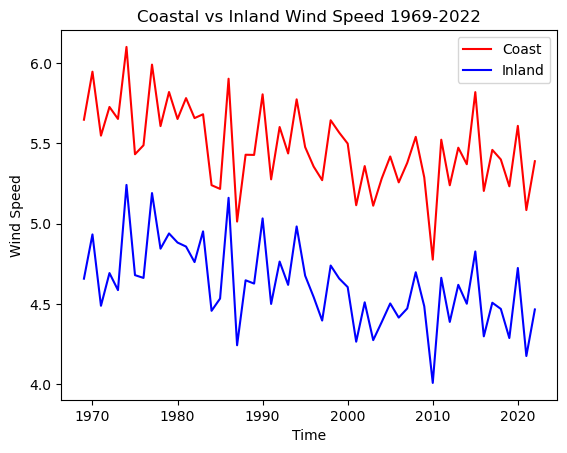

In [14]:
import matplotlib.pyplot as plt
from skimage.measure import block_reduce

tas_coast = block_reduce(coastal_data, block_size=(12, 1, 1), func=np.mean, cval=np.mean(coastal_data))
temp_coast = np.nanmean(tas_coast, axis=(1, 2))

tas_inland = block_reduce(non_coastal_data, block_size=(12, 1, 1), func=np.mean, cval=np.mean(non_coastal_data))
temp_inland = np.nanmean(tas_inland, axis=(1, 2))

time = np.arange(1969,2023)

plt.plot(time,temp_coast, 'r', label='Coast')
plt.plot(time, temp_inland, 'b', label='Inland')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.title('Coastal vs Inland Wind Speed 1969-2022')
plt.legend()

The rate of change of the annual Coast temperature is -0.00837 ± 0.00199 m/s
95% Confidence Interval for the slope: (-0.01, -0.00)
T statistic Coast -4.200132952000365
P-value Coast 0.00010481132900652668
Z-score Coast -4.200132952000365
The rate of change of the annual temperature for inland of U.K. is -0.00869 ± 0.00192 m/s
95% Confidence Interval for the slope: (-0.01, -0.00)
T statistic Inland -4.5193824639073705
P-value Inland 3.607260804794343e-05
Z-score Inland -4.5193824639073705


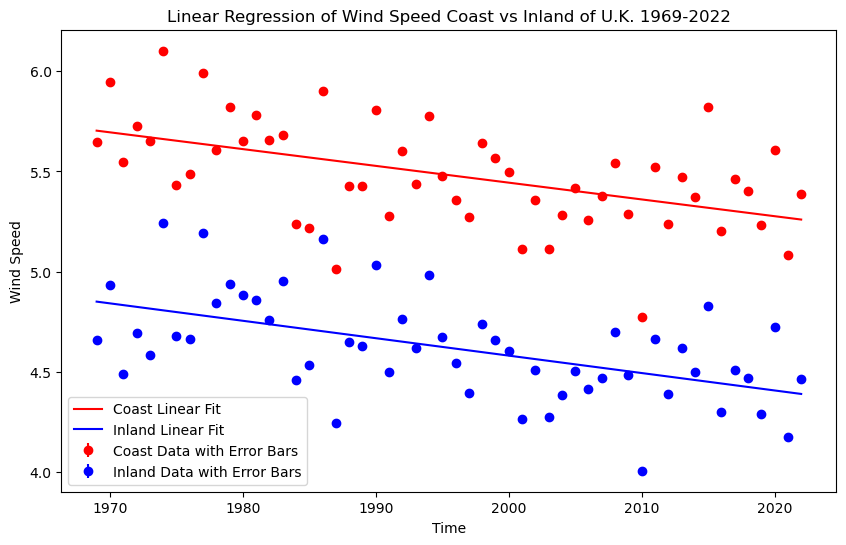

In [15]:
import statsmodels.api as sm
from scipy import stats

err = 0.001

X_with_constant_Coast = sm.add_constant(time)
X_with_constant_inland = sm.add_constant(time)    

# Performing Ordinary Least Squares regression
weights_Coast = 1 / np.square(err)
model_Coast = sm.WLS(temp_coast, X_with_constant_Coast, weights=weights_Coast)
results_Coast = model_Coast.fit()

# Extracting information from the regression results
slope_Coast = results_Coast.params[1]  # Index 1 corresponds to the slope coefficient
intercept_Coast = results_Coast.params[0]  # Index 0 corresponds to the intercept
slope_error_Coast = results_Coast.bse[1]
intercept_error_Coast = results_Coast.bse[0]

print(f'The rate of change of the annual Coast temperature is {slope_Coast:.5f} ± {slope_error_Coast:.5f} m/s')
conf_int_Coast = results_Coast.conf_int(alpha=0.05)  
lower_bound_Coast, upper_bound_Coast = conf_int_Coast[1] 
print(f'95% Confidence Interval for the slope: ({lower_bound_Coast:.2f}, {upper_bound_Coast:.2f})')

# Printing results
t_statistic_Coast = results_Coast.tvalues[1]  # Index 1 corresponds to the slope coefficient
degrees_of_freedom_Coast = len(temp_coast)- 2
p_value_Coast = 2 * (1 - stats.t.cdf(np.abs(t_statistic_Coast), df=degrees_of_freedom_Coast))

null_hypothesis_value = 0
z_score_Coast = (slope_Coast - null_hypothesis_value) / results_Coast.bse[1]

print('T statistic Coast', t_statistic_Coast)
print('P-value Coast', p_value_Coast)
print('Z-score Coast', z_score_Coast)


# Performing Ordinary Least Squares regression
weights_inland = 1 / np.square(err)
model_inland = sm.WLS(temp_inland, X_with_constant_inland, weights=weights_inland)
results_inland = model_inland.fit()

# Extracting information from the regression results
slope_inland = results_inland.params[1]  # Index 1 corresponds to the slope coefficient
intercept_inland = results_inland.params[0]  # Index 0 corresponds to the intercept
slope_error_inland = results_inland.bse[1]
intercept_error_inland = results_inland.bse[0]

print(f'The rate of change of the annual temperature for inland of U.K. is {slope_inland:.5f} ± {slope_error_inland:.5f} m/s')
conf_int_inland = results_inland.conf_int(alpha=0.05)  
lower_bound_inland, upper_bound_inland = conf_int_inland[1] 
print(f'95% Confidence Interval for the slope: ({lower_bound_inland:.2f}, {upper_bound_inland:.2f})')

# Printing results
t_statistic_inland = results_inland.tvalues[1]  # Index 1 corresponds to the slope coefficient
degrees_of_freedom_inland = len(temp_inland)- 2
p_value_inland = 2 * (1 - stats.t.cdf(np.abs(t_statistic_inland), df=degrees_of_freedom_inland))

null_hypothesis_value = 0
z_score_inland = (slope_inland - null_hypothesis_value) / results_inland.bse[1]

print('T statistic Inland', t_statistic_inland)
print('P-value Inland', p_value_inland)
print('Z-score Inland', z_score_inland)


plt.figure(figsize=(10, 6))

# Scatter plot of the data
plt.errorbar(time, temp_coast, yerr=err, fmt='o', color='red', label='Coast Data with Error Bars')

# Plotting the regression line
plt.plot(time, results_Coast.fittedvalues, color='red', label='Coast Linear Fit')

plt.errorbar(time, temp_inland, yerr=err, fmt='o', color='blue', label='Inland Data with Error Bars')

# Plotting the regression line
plt.plot(time, results_inland.fittedvalues, color='blue', label='Inland Linear Fit')


plt.title('Linear Regression of Wind Speed Coast vs Inland of U.K. 1969-2022')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

## North South Coast

In [16]:
import xarray as xr
from pyproj import Proj, transform
import geopandas as gpd
import numpy as np

data = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=True)

# Define the coordinate reference systems
wgs84 = Proj(init='epsg:4326')  # WGS84 coordinate system (latitude and longitude)
osgb36 = Proj(init='epsg:27700')  # OS National Grid coordinate system

# Load the shapefile with coastline coordinates
shapefile_path = r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\GBR_adm0.shp"
gdf_coastline = gpd.read_file(shapefile_path)

C:\Users\iarla\miniconda3\envs\jupyter-env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\iarla\miniconda3\envs\jupyter-env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [17]:
# Extract coordinates from the shapefile
lon_coastline = []
lat_coastline = []

# Iterate through each geometry in the GeoDataFrame
for geometry in gdf_coastline['geometry']:
    if geometry.geom_type == 'Polygon':
        # If it's a single Polygon, extract coordinates
        lon, lat = geometry.exterior.xy
        lon_coastline.extend(lon)
        lat_coastline.extend(lat)
    elif geometry.geom_type == 'MultiPolygon':
        # If it's a MultiPolygon, iterate through each Polygon
        for polygon in geometry.geoms:
            lon, lat = polygon.exterior.xy
            lon_coastline.extend(lon)
            lat_coastline.extend(lat)

In [69]:
# Convert shapefile coordinates to OS National Grid
easting_coastline, northing_coastline = transform(wgs84, osgb36, lon_coastline, lat_coastline)

# Round the coordinates to match the grid in the netcdf file
easting_coastline = np.round(easting_coastline, decimals=2)
northing_coastline = np.round(northing_coastline, decimals=2)

# Create a mask based on the coastline coordinates
coastline_mask = np.zeros_like(data['tas'].isel(time=0, drop=True), dtype=bool)
for easting, northing in zip(easting_coastline, northing_coastline):
    idx_x = np.abs(data['projection_x_coordinate'] - easting).argmin()
    idx_y = np.abs(data['projection_y_coordinate'] - northing).argmin()
    coastline_mask[idx_y, idx_x] = True

non_coastline_mask = ~coastline_mask
    
# Apply the mask to the climate data
coast = data['tas'].where(coastline_mask)
non_coast = np.array(data['tas'].where(non_coastline_mask))

coastal_data = np.array(coast)
non_coastal_data = np.array(non_coast)

C:\Users\iarla\AppData\Local\Temp\ipykernel_11208\598543567.py:2: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  easting_coastline, northing_coastline = transform(wgs84, osgb36, lon_coastline, lat_coastline)


In [75]:
tas_array = np.array(data['tas'])
lat = np.array(data['latitude'])


northern_lat_threshold = 54.0
northern_lat_index = np.where(lat >= northern_lat_threshold)[0][0]

num_years = 1668 // 12
temp_reshaped = coastal_data[:num_years * 12].reshape(num_years, 12, -1)  

temp_mean_north_coast = np.nanmean(temp_reshaped[:, :, northern_lat_index:], axis=(1, 2))

time = np.linspace(1884,2023, 139)

# Define the latitude threshold for southern U.K.
southern_lat_threshold = 54.0

# Find the index where latitude crosses the threshold
southern_lat_index = np.where(lat >= southern_lat_threshold)[0][0]

# Calculate the mean temperature for each year in the southern U.K.
temp_mean_south_coast = np.empty(num_years)
for i in range(num_years):
    start_idx = i * 12
    end_idx = (i + 1) * 12
    temp_year = coastal_data[start_idx:end_idx, :southern_lat_index, :]
    temp_mean_south_coast[i] = np.nanmean(temp_year)

In [87]:
northern_lat_threshold = 54.0
northern_lat_index = np.where(lat >= northern_lat_threshold)[0][0]

num_years = 1668 // 12
temp_reshaped = non_coastal_data[:num_years * 12].reshape(num_years, 12, -1)  

temp_mean_north_inland = np.nanmean(temp_reshaped[:, :, northern_lat_index:], axis=(1, 2))

time = np.linspace(1884,2023, 139)

# Define the latitude threshold for southern U.K.
southern_lat_threshold = 54.0

# Find the index where latitude crosses the threshold
southern_lat_index = np.where(lat >= southern_lat_threshold)[0][0]

# Calculate the mean temperature for each year in the southern U.K.
temp_mean_south_inland = np.empty(num_years)
for i in range(num_years):
    start_idx = i * 12
    end_idx = (i + 1) * 12
    temp_year = non_coastal_data[start_idx:end_idx, :southern_lat_index, :]
    temp_mean_south_inland[i] = np.nanmean(temp_year)

## Southern U.K. Coast vs Inland

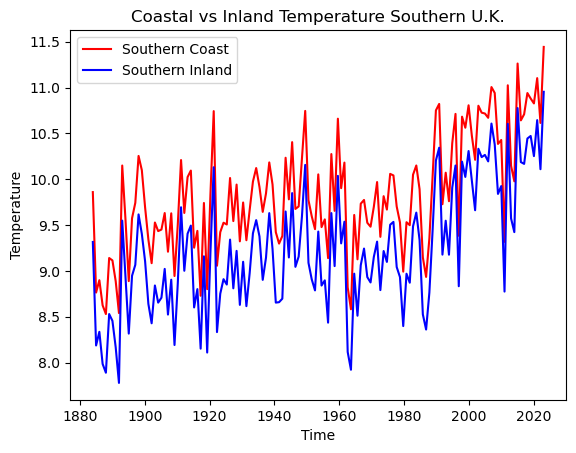

In [88]:
plt.plot(time, temp_mean_south_coast, 'r', label='Southern Coast')
plt.plot(time, temp_mean_south_inland, 'b', label='Southern Inland')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Coastal vs Inland Temperature Southern U.K.')
plt.legend()

The rate of change of the annual Coast temperature is 0.00956 ± 0.00106 °C
95% Confidence Interval for the slope: (0.01, 0.01)
T statistic Coast 9.020174608977491
P-value Coast 1.5543122344752192e-15
Z-score Coast 9.020174608977491
The rate of change of the annual temperature for inland of U.K. is 0.01086 ± 0.00112 °C
95% Confidence Interval for the slope: (0.01, 0.01)
T statistic Inland 9.689862617542058
P-value Inland 0.0
Z-score Inland 9.689862617542058


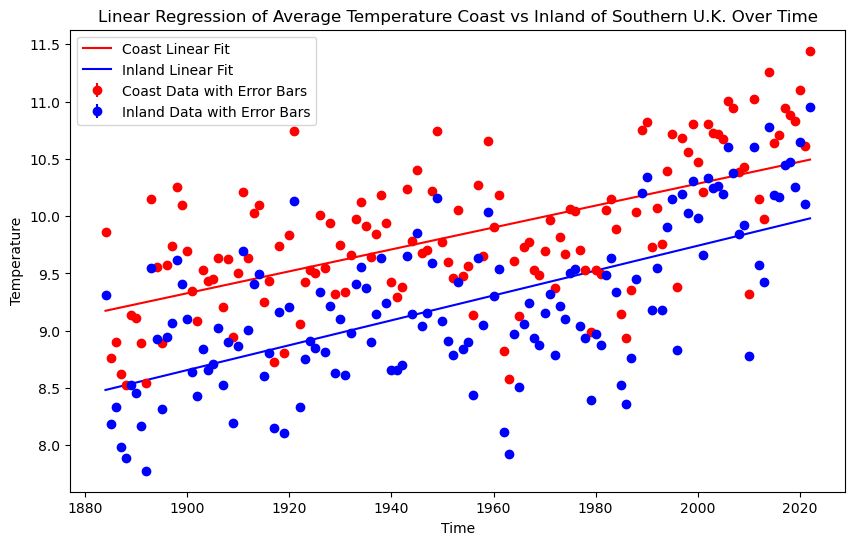

In [89]:
import statsmodels.api as sm
from scipy import stats

time = np.arange(1884,2023)

err = 0.001

X_with_constant_Coast = sm.add_constant(time)
X_with_constant_inland = sm.add_constant(time)    

# Performing Ordinary Least Squares regression
weights_Coast = 1 / np.square(err)
model_Coast = sm.WLS(temp_mean_south_coast, X_with_constant_Coast, weights=weights_Coast)
results_Coast = model_Coast.fit()

# Extracting information from the regression results
slope_Coast = results_Coast.params[1]  # Index 1 corresponds to the slope coefficient
intercept_Coast = results_Coast.params[0]  # Index 0 corresponds to the intercept
slope_error_Coast = results_Coast.bse[1]
intercept_error_Coast = results_Coast.bse[0]

print(f'The rate of change of the annual Coast temperature is {slope_Coast:.5f} ± {slope_error_Coast:.5f} °C')
conf_int_Coast = results_Coast.conf_int(alpha=0.05)  
lower_bound_Coast, upper_bound_Coast = conf_int_Coast[1] 
print(f'95% Confidence Interval for the slope: ({lower_bound_Coast:.2f}, {upper_bound_Coast:.2f})')

# Printing results
t_statistic_Coast = results_Coast.tvalues[1]  # Index 1 corresponds to the slope coefficient
degrees_of_freedom_Coast = len(temp_mean_south_coast)- 2
p_value_Coast = 2 * (1 - stats.t.cdf(np.abs(t_statistic_Coast), df=degrees_of_freedom_Coast))

null_hypothesis_value = 0
z_score_Coast = (slope_Coast - null_hypothesis_value) / results_Coast.bse[1]

print('T statistic Coast', t_statistic_Coast)
print('P-value Coast', p_value_Coast)
print('Z-score Coast', z_score_Coast)


# Performing Ordinary Least Squares regression
weights_inland = 1 / np.square(err)
model_inland = sm.WLS(temp_mean_south_inland, X_with_constant_inland, weights=weights_inland)
results_inland = model_inland.fit()

# Extracting information from the regression results
slope_inland = results_inland.params[1]  # Index 1 corresponds to the slope coefficient
intercept_inland = results_inland.params[0]  # Index 0 corresponds to the intercept
slope_error_inland = results_inland.bse[1]
intercept_error_inland = results_inland.bse[0]

print(f'The rate of change of the annual temperature for inland of U.K. is {slope_inland:.5f} ± {slope_error_inland:.5f} °C')
conf_int_inland = results_inland.conf_int(alpha=0.05)  
lower_bound_inland, upper_bound_inland = conf_int_inland[1] 
print(f'95% Confidence Interval for the slope: ({lower_bound_inland:.2f}, {upper_bound_inland:.2f})')

# Printing results
t_statistic_inland = results_inland.tvalues[1]  # Index 1 corresponds to the slope coefficient
degrees_of_freedom_inland = len(temp_mean_south_inland)- 2
p_value_inland = 2 * (1 - stats.t.cdf(np.abs(t_statistic_inland), df=degrees_of_freedom_inland))

null_hypothesis_value = 0
z_score_inland = (slope_inland - null_hypothesis_value) / results_inland.bse[1]

print('T statistic Inland', t_statistic_inland)
print('P-value Inland', p_value_inland)
print('Z-score Inland', z_score_inland)


plt.figure(figsize=(10, 6))

# Scatter plot of the data
plt.errorbar(time, temp_mean_south_coast, yerr=err, fmt='o', color='red', label='Coast Data with Error Bars')

# Plotting the regression line
plt.plot(time, results_Coast.fittedvalues, color='red', label='Coast Linear Fit')

plt.errorbar(time, temp_mean_south_inland, yerr=err, fmt='o', color='blue', label='Inland Data with Error Bars')

# Plotting the regression line
plt.plot(time, results_inland.fittedvalues, color='blue', label='Inland Linear Fit')


plt.title('Linear Regression of Average Temperature Coast vs Inland of Southern U.K. Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


## Northern U.K. Coast vs Inland

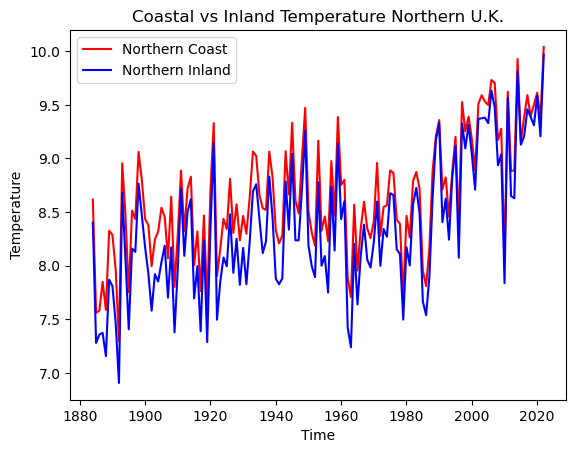

In [90]:
plt.plot(time, temp_mean_north_coast, 'r', label='Northern Coast')
plt.plot(time, temp_mean_north_inland, 'b', label='Northern Inland')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Coastal vs Inland Temperature Northern U.K.')
plt.legend()

The rate of change of the annual Coast temperature is 0.00811 ± 0.00096 °C
95% Confidence Interval for the slope: (0.01, 0.01)
T statistic Coast 8.486315427963529
P-value Coast 3.086420008457935e-14
Z-score Coast 8.486315427963529
The rate of change of the annual temperature for inland of U.K. is 0.00993 ± 0.00105 °C
95% Confidence Interval for the slope: (0.01, 0.01)
T statistic Inland 9.50445615209664
P-value Inland 2.220446049250313e-16
Z-score Inland 9.50445615209664


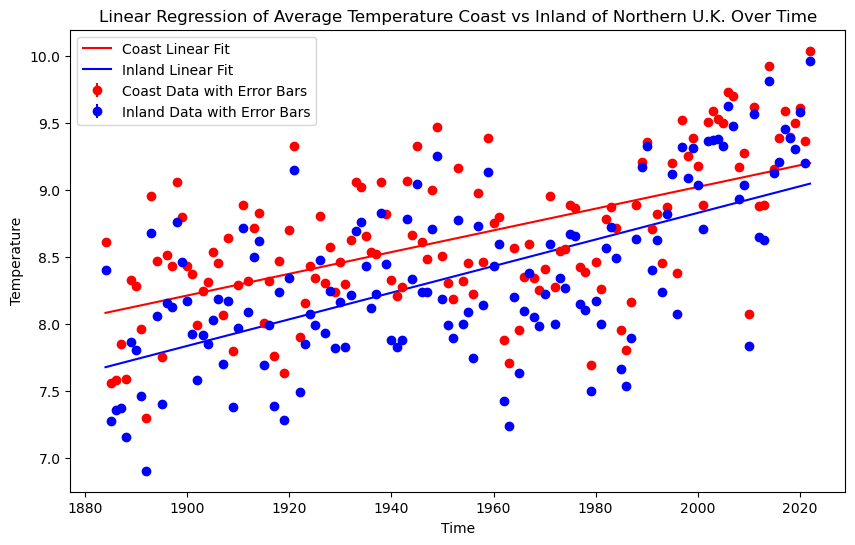

In [91]:
import statsmodels.api as sm
from scipy import stats

time = np.arange(1884,2023)

err = 0.001

X_with_constant_Coast = sm.add_constant(time)
X_with_constant_inland = sm.add_constant(time)    

# Performing Ordinary Least Squares regression
weights_Coast = 1 / np.square(err)
model_Coast = sm.WLS(temp_mean_north_coast, X_with_constant_Coast, weights=weights_Coast)
results_Coast = model_Coast.fit()

# Extracting information from the regression results
slope_Coast = results_Coast.params[1]  # Index 1 corresponds to the slope coefficient
intercept_Coast = results_Coast.params[0]  # Index 0 corresponds to the intercept
slope_error_Coast = results_Coast.bse[1]
intercept_error_Coast = results_Coast.bse[0]

print(f'The rate of change of the annual Coast temperature is {slope_Coast:.5f} ± {slope_error_Coast:.5f} °C')
conf_int_Coast = results_Coast.conf_int(alpha=0.05)  
lower_bound_Coast, upper_bound_Coast = conf_int_Coast[1] 
print(f'95% Confidence Interval for the slope: ({lower_bound_Coast:.2f}, {upper_bound_Coast:.2f})')

# Printing results
t_statistic_Coast = results_Coast.tvalues[1]  # Index 1 corresponds to the slope coefficient
degrees_of_freedom_Coast = len(temp_mean_north_coast)- 2
p_value_Coast = 2 * (1 - stats.t.cdf(np.abs(t_statistic_Coast), df=degrees_of_freedom_Coast))

null_hypothesis_value = 0
z_score_Coast = (slope_Coast - null_hypothesis_value) / results_Coast.bse[1]

print('T statistic Coast', t_statistic_Coast)
print('P-value Coast', p_value_Coast)
print('Z-score Coast', z_score_Coast)


# Performing Ordinary Least Squares regression
weights_inland = 1 / np.square(err)
model_inland = sm.WLS(temp_mean_north_inland, X_with_constant_inland, weights=weights_inland)
results_inland = model_inland.fit()

# Extracting information from the regression results
slope_inland = results_inland.params[1]  # Index 1 corresponds to the slope coefficient
intercept_inland = results_inland.params[0]  # Index 0 corresponds to the intercept
slope_error_inland = results_inland.bse[1]
intercept_error_inland = results_inland.bse[0]

print(f'The rate of change of the annual temperature for inland of U.K. is {slope_inland:.5f} ± {slope_error_inland:.5f} °C')
conf_int_inland = results_inland.conf_int(alpha=0.05)  
lower_bound_inland, upper_bound_inland = conf_int_inland[1] 
print(f'95% Confidence Interval for the slope: ({lower_bound_inland:.2f}, {upper_bound_inland:.2f})')

# Printing results
t_statistic_inland = results_inland.tvalues[1]  # Index 1 corresponds to the slope coefficient
degrees_of_freedom_inland = len(temp_mean_north_inland)- 2
p_value_inland = 2 * (1 - stats.t.cdf(np.abs(t_statistic_inland), df=degrees_of_freedom_inland))

null_hypothesis_value = 0
z_score_inland = (slope_inland - null_hypothesis_value) / results_inland.bse[1]

print('T statistic Inland', t_statistic_inland)
print('P-value Inland', p_value_inland)
print('Z-score Inland', z_score_inland)


plt.figure(figsize=(10, 6))

# Scatter plot of the data
plt.errorbar(time, temp_mean_north_coast, yerr=err, fmt='o', color='red', label='Coast Data with Error Bars')

# Plotting the regression line
plt.plot(time, results_Coast.fittedvalues, color='red', label='Coast Linear Fit')

plt.errorbar(time, temp_mean_north_inland, yerr=err, fmt='o', color='blue', label='Inland Data with Error Bars')

# Plotting the regression line
plt.plot(time, results_inland.fittedvalues, color='blue', label='Inland Linear Fit')


plt.title('Linear Regression of Average Temperature Coast vs Inland of Northern U.K. Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


## East West Coast

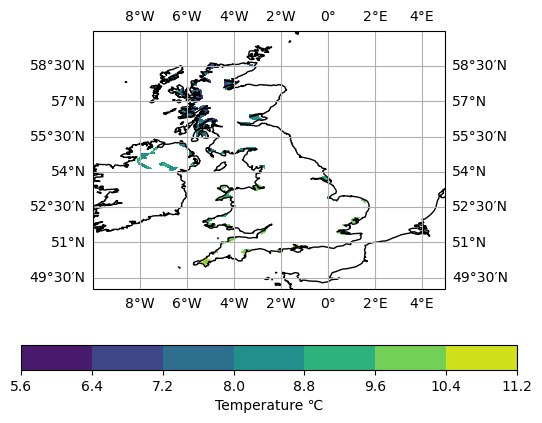

In [116]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


data = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=False)

lons = data.variables['longitude'][:]
lats = data.variables['latitude'][:]

mean_temp = np.mean(coastal_data, axis=0)

plt.figure()

# Create a Cartopy projection with the desired extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-10, 5, 49, 60])

# Add coastlines and gridlines
ax.coastlines(resolution='10m', color='black')
ax.gridlines(draw_labels=True, dms=True)

# Create a contour plot for the mean temperature field
contour = plt.contourf(lons, lats, mean_temp, cmap=plt.cm.viridis)

# Add a colorbar
cbar = plt.colorbar(contour, orientation='horizontal')
cbar.set_label(u"Temperature \u2103")

plt.show()

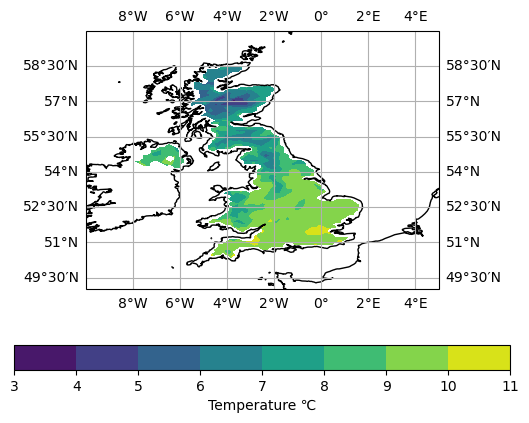

In [113]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


data = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=False)

lons = data.variables['longitude'][:]
lats = data.variables['latitude'][:]

mean_temp = np.mean(non_coastal_data, axis=0)

plt.figure()

# Create a Cartopy projection with the desired extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-10, 5, 49, 60])

# Add coastlines and gridlines
ax.coastlines(resolution='10m', color='black')
ax.gridlines(draw_labels=True, dms=True)

# Create a contour plot for the mean temperature field
contour = plt.contourf(lons, lats, mean_temp, cmap=plt.cm.viridis)

# Add a colorbar
cbar = plt.colorbar(contour, orientation='horizontal')
cbar.set_label(u"Temperature \u2103")

plt.show()